## 车牌映射

In [2]:
vocabulary = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
"琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
"B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
"Y", "Z", "-", "[", "]"]

In [3]:
len(vocabulary)

68

In [4]:
import pandas as pd
import numpy as np
# np.object = object
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

2023-11-15 01:49:27.549414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 01:49:27.694942: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 01:49:27.746207: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 01:49:28.457315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [5]:
# 创建字符到整数的映射
char_to_int = dict((c, i) for i, c in enumerate(vocabulary))

# 创建整数到字符的映射
int_to_char = dict((i, c) for i, c in enumerate(vocabulary))

In [6]:
# 预处理函数，用于读取图片并调整大小
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
def preprocess_image(filename, img_folder, img_size):
    img_path = os.path.join(img_folder, f"{filename}.jpg")
    img = cv2.imread(img_path)
    # print(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # denoised_image = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21) # 进行去噪处理
    # plate_image = cv2.dilate(denoised_image, kernel)
    img = cv2.resize(img, (80, 30))
    # img = find_plate(img)
    
    return img

# 将车牌标签转换为独热编码
def encode_labels(labels, max_label_length):
    encoded_labels = np.zeros((len(labels), max_label_length, len(vocabulary)), dtype=np.float32)
    for i, label in enumerate(labels):
        label_length = len(label)
        for j, char in enumerate(label):
            encoded_labels[i, j, char_to_int[char]] = 1
        # 如果车牌短于最大长度，使用结束符来填充
        for k in range(label_length, max_label_length):
            encoded_labels[i, k, char_to_int["-"]] = 1
    return encoded_labels


In [7]:
# 载入CSV文件
df = pd.read_csv('IMtrain_license_lables.csv')

## 数据预处理，X存放图片，Y存放标签

In [8]:
# 数据预处理
img_folder = 'train_process'
img_size = (30, 80)
X = []
y = []

for index, row in df.iterrows():
    # 跳过不包含车牌的图片
    image_path = os.path.join(img_folder, f"{row['image_name']}.jpg")
    if not os.path.exists(image_path) or row['data_true'] == '[]':
        continue
    img = preprocess_image(row['image_name'], img_folder, img_size)
    label = row['data_true']
    X.append(img)
    y.append(label)
    # if len(X)%1000==0:
    # print("complete.... ",len(X))

In [9]:
len(X)

20180

In [10]:
len(X),len(y)
y[0]

'皖AP1E08'

## 转换成独热编码

In [11]:

label_name_len = len(y[0])+1

# 将字符串数字化
def text2vec(text):
    text = text.ljust(label_name_len, '-')
    vector = np.zeros([label_name_len, len(vocabulary)])
    for i, c in enumerate(text):
        idx = vocabulary.index(c)
        vector[i][idx] = 1.0
    return vector

all_labels = [text2vec(i) for i in y]

In [12]:
all_labels[0][7]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [13]:
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, all_labels, test_size=0.2, random_state=42)

In [15]:
#数据增强
def augment(image, label):
  image = tf.image.random_brightness(image, 0.1) 
  image = tf.image.random_contrast(image, 0.8, 1.2)
  
  return image, label

In [16]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# 应用增强
train_data = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2023-11-15 01:50:02.336775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 01:50:02.972454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22298 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:52:00.0, compute capability: 8.6


In [17]:
BATCH_SIZE = 256

train_data = train_data.shuffle(buffer_size=1024).batch(BATCH_SIZE) 
test_data = test_data.batch(BATCH_SIZE)

## 建立模型

In [18]:
# 建立模型
def getCNNModel(shape):
    model = Sequential([
        Conv2D(32, (3, 3),  padding = "same", activation='relu', input_shape=(30, 80, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides =2, padding = "same"),
        Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides = 2 , padding = 'same'),
        Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2), strides = 2 , padding = 'same'),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(label_name_len * len(vocabulary), activation='softmax'),
        # 将输出重新构造为标签的形状
        Reshape((label_name_len, len(vocabulary)))
    ])
    return model

In [19]:
initial_learning_rate = 1e-3

#自适应学习率
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=75,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model = getCNNModel(X_train[0].shape)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

In [21]:

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=120
)

Epoch 1/120


2023-11-15 01:50:06.823348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-11-15 01:50:08.783690: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


64/64 [==============================] - 6s 32ms/step - loss: 2.4357 - accuracy: 0.4055 - val_loss: 2.4288 - val_accuracy: 0.4648
Epoch 2/120
64/64 [==============================] - 2s 27ms/step - loss: 1.8837 - accuracy: 0.5026 - val_loss: 1.6852 - val_accuracy: 0.6250
Epoch 3/120
64/64 [==============================] - 2s 27ms/step - loss: 1.4996 - accuracy: 0.6006 - val_loss: 1.2426 - val_accuracy: 0.7246
Epoch 4/120
64/64 [==============================] - 2s 27ms/step - loss: 1.2304 - accuracy: 0.6635 - val_loss: 0.9818 - val_accuracy: 0.7751
Epoch 5/120
64/64 [==============================] - 2s 31ms/step - loss: 1.0415 - accuracy: 0.7059 - val_loss: 0.7652 - val_accuracy: 0.8111
Epoch 6/120
64/64 [==============================] - 2s 33ms/step - loss: 0.9196 - accuracy: 0.7350 - val_loss: 0.6485 - val_accuracy: 0.8412
Epoch 7/120
64/64 [==============================] - 3s 39ms/step - loss: 0.8212 - accuracy: 0.7600 - val_loss: 0.5455 - val_accuracy: 0.8617
Epoch 8/120
64/64 

In [22]:
# 测试图片读取
test_img = cv2.imread("train/4137.jpg")


denoised_test_image = cv2.fastNlMeansDenoisingColored(test_img, None, 10, 10, 7, 21) # 进行去噪处理
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
plate_test_image = cv2.dilate(denoised_test_image, kernel)
test_img = cv2.resize(plate_test_image, (80, 30))
img_array = tf.expand_dims(test_img, 0) 
predictions = model.predict(img_array)

def vec2text(vec):
    text = []
    for c in vec:
        if vocabulary[c] != '-':  # 忽略填充字符
            text.append(vocabulary[c])
    return "".join(text)
vec2text(np.argmax(predictions, axis=2)[0])

1/1 [==============================] - 0s 197ms/step


'皖AZ1U29'

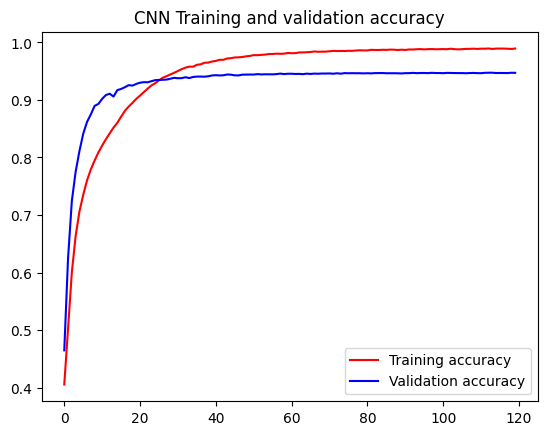

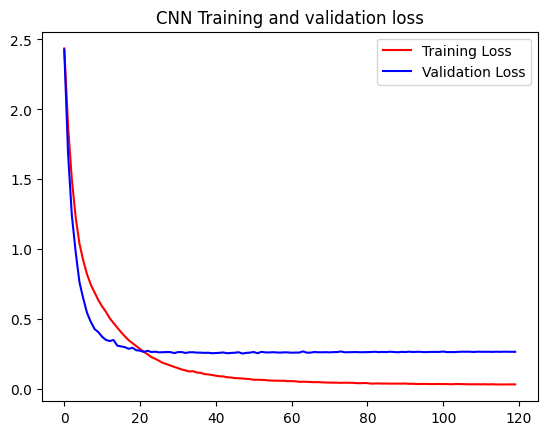

In [23]:
# 获取准确率与损失函数情况
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('CNN Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN Training and validation loss')
plt.legend()

plt.show()

## 保存模型

In [24]:
model.save('plateRec_model', save_format='tf')

INFO:tensorflow:Assets written to: plateRec_model0.98/assets


INFO:tensorflow:Assets written to: plateRec_model0.98/assets
